In [1]:
import pickle
from glob import glob 

import pandas as pd
from tqdm import tqdm 
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torchmetrics
from umap import UMAP

from erc.constants import idx2emotion, emotion2idx

sns.set_style("whitegrid")
# sns.set_theme()

In [2]:
from datasets import load_from_disk

ds = load_from_disk("./kemdy19-kemdy20_valid4_multilabelFalse_rdeuceTrue/")

In [3]:
df = pd.DataFrame({
    "emotion": ds["emotion"],
    "valence": ds["valence"],
    "arousal": ds["arousal"],
})
df["emotion"] = df.emotion.apply(idx2emotion.get).values
df.sort_values(by="emotion", key=lambda s: s.apply(emotion2idx.get), inplace=True)

In [4]:
# load pickle --> RAM 
SAVE_PATH = "./RobertaL_valid_output_hub"

total_emotion = pd.DataFrame()
total_logits = pd.DataFrame()

result_fnames = glob(SAVE_PATH+'/*.pickle')
pbar = tqdm(total=len(result_fnames), 
            iterable=result_fnames)

for pickle_name in pbar:
    # load
    with open(pickle_name, 'rb') as f:
        data = pickle.load(f)
    tmp_emotion = pd.DataFrame(data['emotion'].cpu().detach().numpy())
    pred = data["cls_pred"]
    tmp_pred = pd.DataFrame(pred.argmax(dim=1).cpu().numpy())
    tmp_logits = pd.DataFrame(pred.cpu().numpy())
    
    total_logits = pd.concat(objs=[total_logits, tmp_logits])
    
    total_emotion = pd.concat(objs=[total_emotion,
                                    pd.concat([tmp_emotion, tmp_pred], axis=1)],
                              axis=0)

del tmp_emotion

total_emotion.columns = ['emotion', "pred"]

100%|██████████| 585/585 [00:08<00:00, 65.33it/s] 


In [5]:
# load pickle --> RAM 
SAVE_PATH = "./RobertaL_valid_results"

total_emotion = pd.DataFrame()
total_emb = pd.DataFrame()
total_logits = pd.DataFrame()

result_fnames = glob(SAVE_PATH+'/*.pickle')
pbar = tqdm(total=len(result_fnames), 
            iterable=result_fnames)

target_layer = 15
for pickle_name in pbar:
    # load
    with open(pickle_name, 'rb') as f:
        data = pickle.load(f)
    # print(data)
    tmp_emotion = pd.DataFrame(data['emotion'].detach().numpy())
    tmp_linear = pd.DataFrame(data[target_layer].cpu().numpy())
    pred = data[16][:, :-2]
    tmp_pred = pd.DataFrame(pred.argmax(dim=1).cpu().numpy())
    tmp_logits = pd.DataFrame(pred.cpu().numpy())
    
    total_logits = pd.concat(objs=[total_logits, tmp_logits])
    
    total_emotion = pd.concat(objs=[total_emotion,
                                    pd.concat([tmp_emotion, tmp_pred], axis=1)],
                              axis=0)
    total_emb = pd.concat([total_emb, tmp_linear], axis=0)

del tmp_emotion
del tmp_linear

total_emotion.columns = ['emotion', "pred"]

100%|██████████| 585/585 [00:07<00:00, 76.20it/s]


In [6]:
acc = torchmetrics.Accuracy(task="multiclass", num_classes=7)
f1 = torchmetrics.F1Score(task="multiclass", num_classes=7, average="macro")

In [7]:
correct_indices = (total_emotion.emotion == total_emotion.pred).values
incorrect_indices = (total_emotion.emotion != total_emotion.pred).values

correct_indices.sum(), incorrect_indices.sum()

(4004, 674)

In [8]:
acc(
    preds=torch.from_numpy(total_logits.values),
    target=torch.from_numpy(total_emotion.emotion.values),
)

tensor(0.8559)

/tmp/ipykernel_480609/175133630.py:8: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.scatterplot(x='arousal', y='valence', data=df,


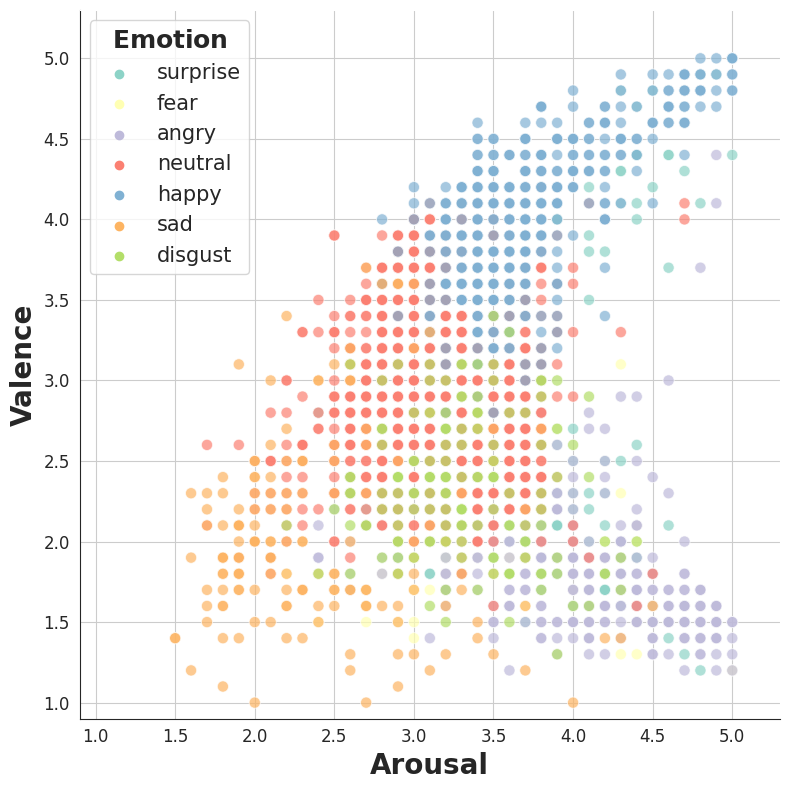

In [9]:
color_palette = sns.color_palette("Set3")
label_fsize = 20
ticks_fsize = 12
legend_size = 15
plt.rcParams["axes.edgecolor"] = "0.15"

_, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='arousal', y='valence', data=df, 
                     hue="emotion",
                     palette=color_palette,
                     s=65, ax=ax,
                         alpha=0.7)
ax.set_xlim((0.9, 5.3))
ax.set_ylim((0.9, 5.3))
ax.legend()

ax.spines['right'].set_color(None)
ax.spines['top'].set_color(None)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.legend(
            loc='best',
           fontsize=legend_size,title=r'$\bf{Emotion}$',frameon=True,
           fancybox=True ,
           title_fontsize=18,
           )
plt.xlabel('Arousal', fontweight='bold', fontsize=label_fsize)
plt.ylabel('Valence', fontweight='bold', fontsize=label_fsize)
plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],size = ticks_fsize)
plt.yticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],size = ticks_fsize)
plt.tight_layout()
# plt.savefig('./etri-eda.svg')
plt.show()

In [36]:
def plot_rd(data: np.ndarray,
            total_emotion: pd.DataFrame,
            correct_only: bool = True,
            incorrect_only: bool = False,
            dim_reduction: str = "pca",
            n_components: int = 2,
            n_sampling: int = 100,
            plot_type: str = "joint",
            title: str = "",
            remove_neutral: bool = False,
            **kwargs):
    
    # Umap config
    if dim_reduction == "umap":
        if not kwargs.get("n_neighbors"):
            kwargs["n_neighbors"] = 15
        if not kwargs.get("min_dist"):
            kwargs["min_dist"] = 0.6

    # Dimensionality Reduction
    if dim_reduction is not None:
        tool = {
            "pca": PCA,
            "tsne": TSNE,
            "umap": UMAP,
        }[dim_reduction](n_components=n_components, **kwargs)
        reduced_data = tool.fit_transform(data)
    else:
        # Pre-transformed data
        reduced_data = data
    # Sample correct
    if correct_only:
        correct_indices = (total_emotion.emotion == total_emotion.pred).values
        reduced_data = reduced_data[correct_indices]
        total_emotion = total_emotion[correct_indices]
    if incorrect_only:
        incorrect_indices = (total_emotion.emotion != total_emotion.pred).values
        reduced_data = reduced_data[incorrect_indices]
        total_emotion = total_emotion[incorrect_indices]

    if n_sampling > 0:
        tmp = pd.DataFrame()
        for emotion in total_emotion.emotion.unique():
            _sub_df = total_emotion[total_emotion.emotion == emotion]
            ns = min(len(_sub_df), n_sampling)
            _sub_df = _sub_df.sample(n=ns)
            tmp = pd.concat([tmp, _sub_df])
        total_emotion = tmp
        
    sns_cmap = sns.color_palette("Set3")
    if remove_neutral:
        reduced_data = reduced_data[total_emotion.emotion != "neutral"]

    total_df = pd.DataFrame(reduced_data)
    total_df.columns = ["dim2", "dim1"]
    total_df["dim1"] = -total_df["dim1"]
    total_df["emotion"] = total_emotion.emotion.apply(idx2emotion.get).values
    total_df.sort_values(by="emotion", inplace=True)
    total_df.sort_values(by="emotion", key=lambda s: s.apply(emotion2idx.get), inplace=True)
    
    total_df["dim1"] = total_df["dim1"] // 0.4
    total_df["dim2"] = total_df["dim2"] // 0.4
    
    fig, ax = plt.subplots(figsize=(8, 8))
    if plot_type == "scatter":
        total_df = total_df.round({"dim1": 1, "dim2": 1})
        sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                        marker='.', alpha=0.85, s=320, palette=sns_cmap, ax=ax)
    elif plot_type == "joint":
        sns.jointplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                      kind="kde", palette=sns_cmap, fill=True, alpha=0.6)
    elif plot_type == "kde":
        sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                    palette=sns_cmap, fill=True, alpha=0.6, ax=ax, levels=2)
    elif plot_type == "kde_scatter":
        sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                    palette=sns_cmap, fill=True, alpha=0.4, ax=ax, gridsize=500)
        sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion",
                        marker='.', alpha=0.7, s=320, palette=sns_cmap, ax=ax)
    
    ax.spines['right'].set_color(None)
    # ax.spines['left'].set_color(None)
    ax.spines['top'].set_color(None)
    # ax.spines['bottom'].set_color(None)
    
    # ax.legend(loc="best",
    #           fontsize=10,
    #           title=r"$\bf{Emotion}$",
    #           frameon=True,
    #           fancybox=True,
    #           title_fontsize=13)
    ax.get_legend().remove()
    
    ax.set_xlabel(r'$\bf{UMAP_1}$', fontweight='bold', fontsize=label_fsize)
    ax.set_ylabel(r'$\bf{UMAP_2}$', fontweight='bold', fontsize=label_fsize)
    
    fig.tight_layout()

/tmp/ipykernel_480609/4196373659.py:67: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion",


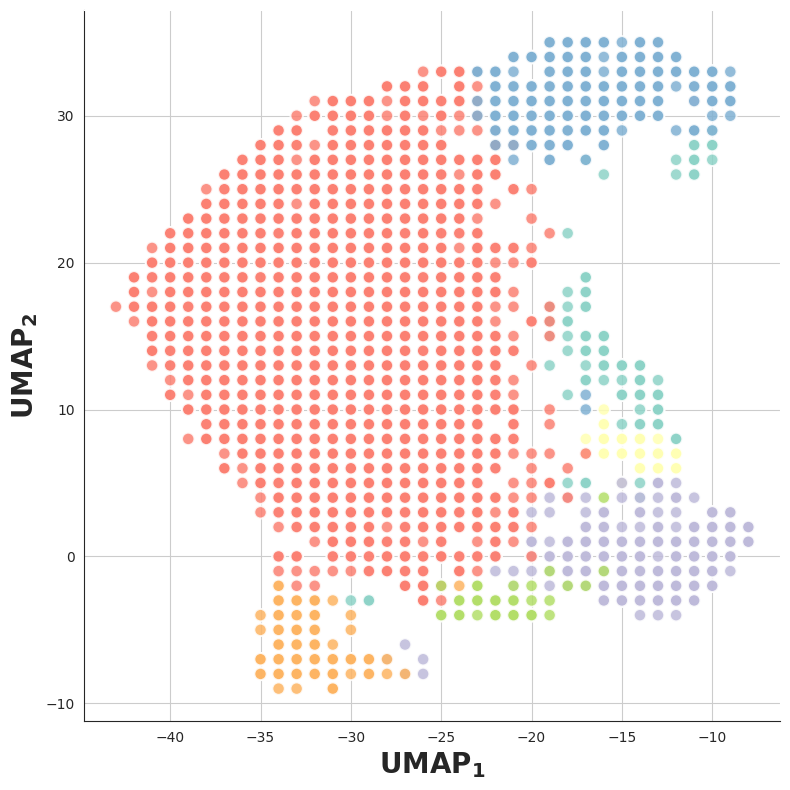

: 

In [37]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        plot_type="scatter",
        n_neighbors=15,
        min_dist=0.6,
        random_state=42)
plt.savefig("./embed.svg")

/tmp/ipykernel_480609/925225216.py:73: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",


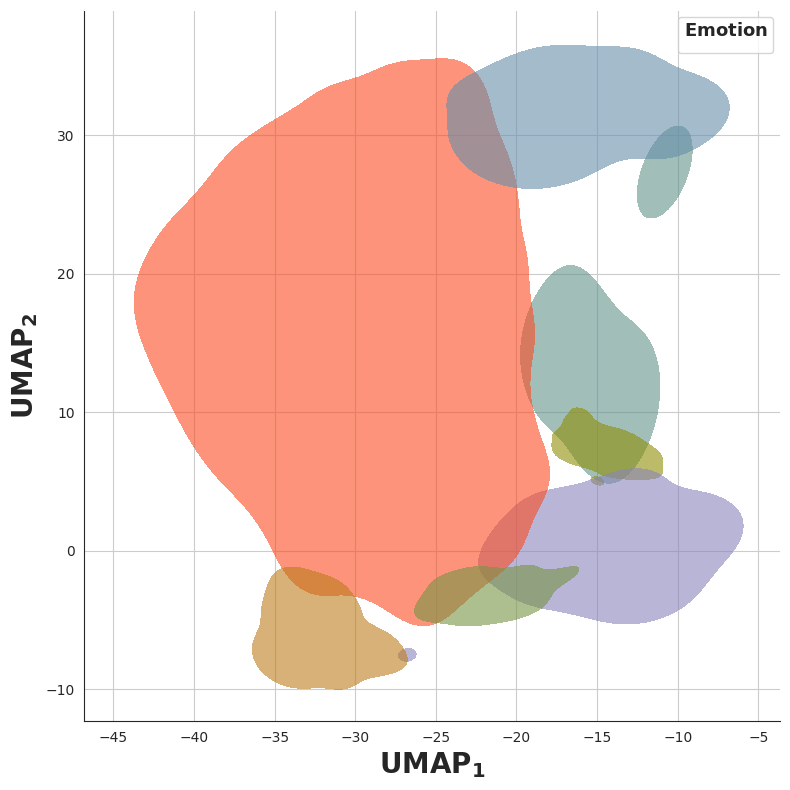

In [32]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        plot_type="kde",
        n_neighbors=15,
        min_dist=0.6,
        random_state=42)

/tmp/ipykernel_480609/925225216.py:76: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",
/tmp/ipykernel_480609/925225216.py:78: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion", linewidth=0.5,


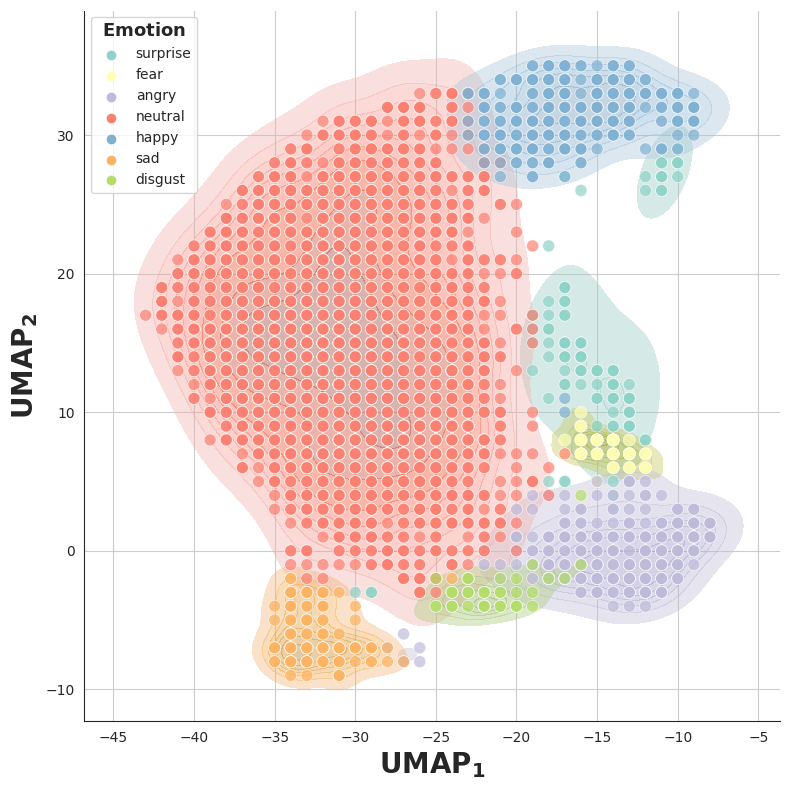

In [30]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        plot_type="kde_scatter",
        n_neighbors=15,
        min_dist=0.6,
        random_state=42)

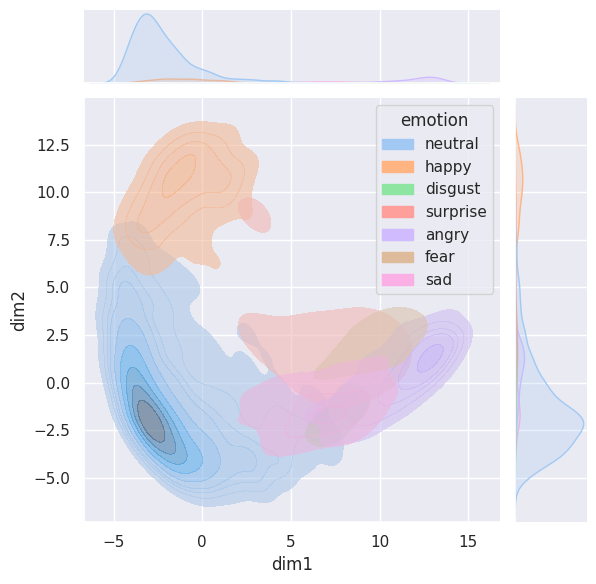

In [ ]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="pca",
        correct_only=True,
        incorrect_only=False,
        title="PCA Linear Pooled | Correct Only",
        n_sampling=0,
        use_jointplot=True,
        random_state=42)

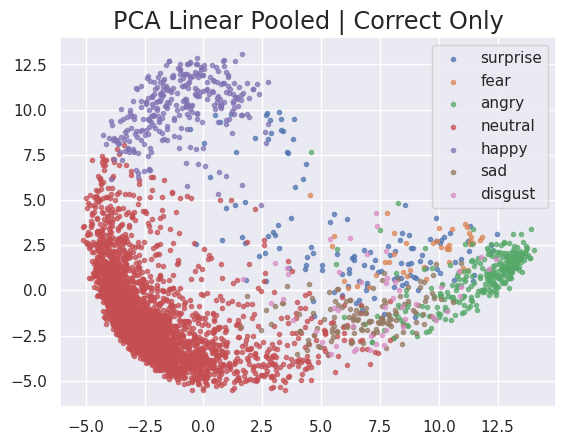

In [ ]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="pca",
        correct_only=True,
        incorrect_only=False,
        title="PCA Linear Pooled | Correct Only",
        n_sampling=0,
        random_state=42)

In [8]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="pca",
        correct_only=False,
        incorrect_only=True,
        title="PCA Linear Pooled | Incorrect Only",
        n_sampling=0,
        random_state=42)

NameError: name 'total_emb' is not defined

## TSNE

In [9]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="tsne",
        correct_only=False,
        incorrect_only=False,
        title="TSNE Linear Pooled",
        n_sampling=0,
        random_state=42)

NameError: name 'total_emb' is not defined

In [10]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="tsne",
        correct_only=True,
        incorrect_only=False,
        title="TSNE Linear Pooled | Correct only",
        n_sampling=0,
        random_state=42)

NameError: name 'total_emb' is not defined

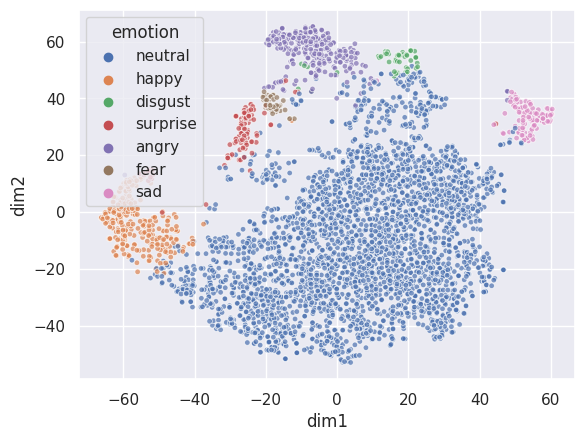

In [40]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="tsne",
        correct_only=True,
        incorrect_only=False,
        title="TSNE Linear Pooled | Correct only",
        n_sampling=0,
        plot_type="scatter",
        random_state=42)

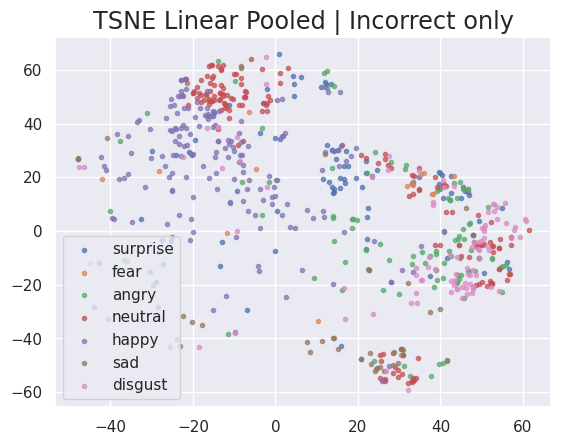

In [24]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="tsne",
        correct_only=False,
        incorrect_only=True,
        title="TSNE Linear Pooled | Incorrect only",
        n_sampling=0,
        random_state=42)

## UMAP

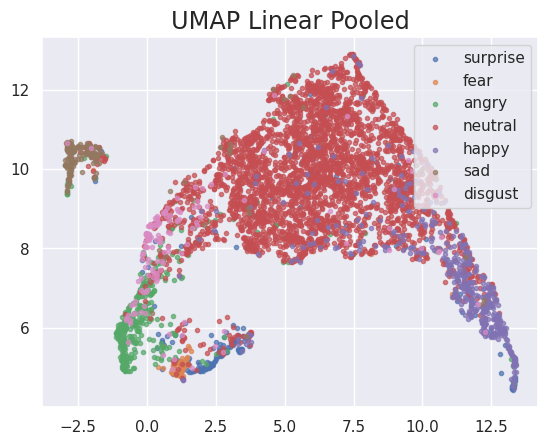

In [25]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=False,
        incorrect_only=False,
        title="UMAP Linear Pooled",
        n_sampling=0,
        random_state=42)

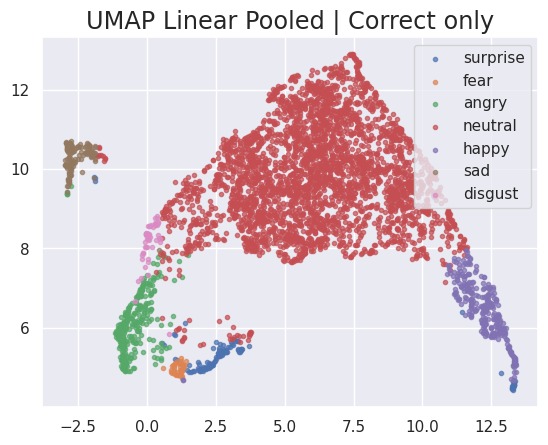

In [26]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        random_state=42)

/tmp/ipykernel_379760/3812692598.py:76: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",
/home/1pha/.conda/envs/erc/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/tmp/ipykernel_379760/3812692598.py:78: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion", linewidth=0.5,


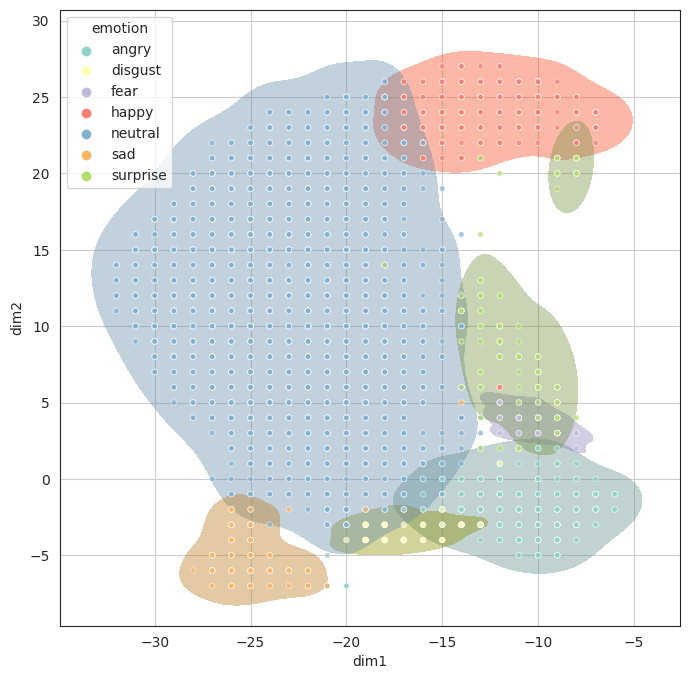

In [109]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        plot_type="kde_scatter",
        n_neighbors=20,
        min_dist=0.6,
        random_state=42)

/tmp/ipykernel_379760/2497574796.py:72: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",
/tmp/ipykernel_379760/2497574796.py:74: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion",


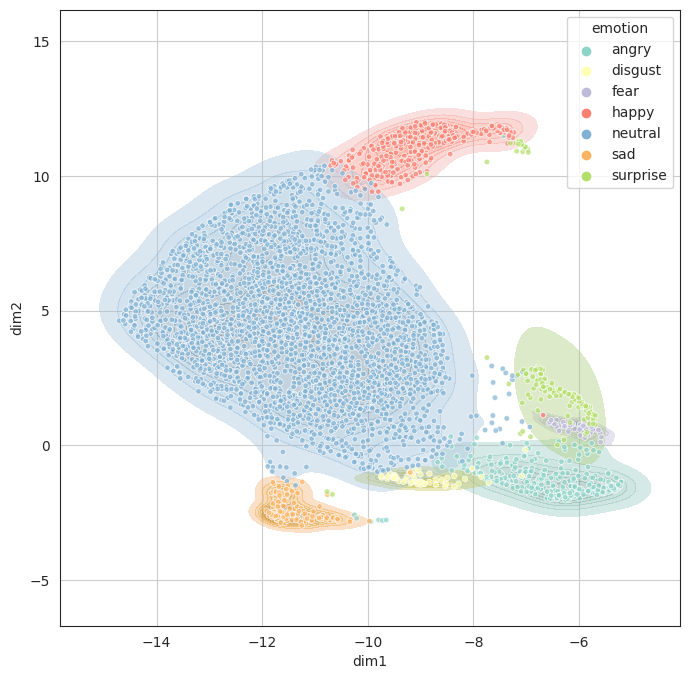

In [63]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        plot_type="kde_scatter",
        n_neighbors=50,
        min_dist=0.3,
        random_state=42)

/tmp/ipykernel_379760/2497574796.py:72: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",
/tmp/ipykernel_379760/2497574796.py:74: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion",


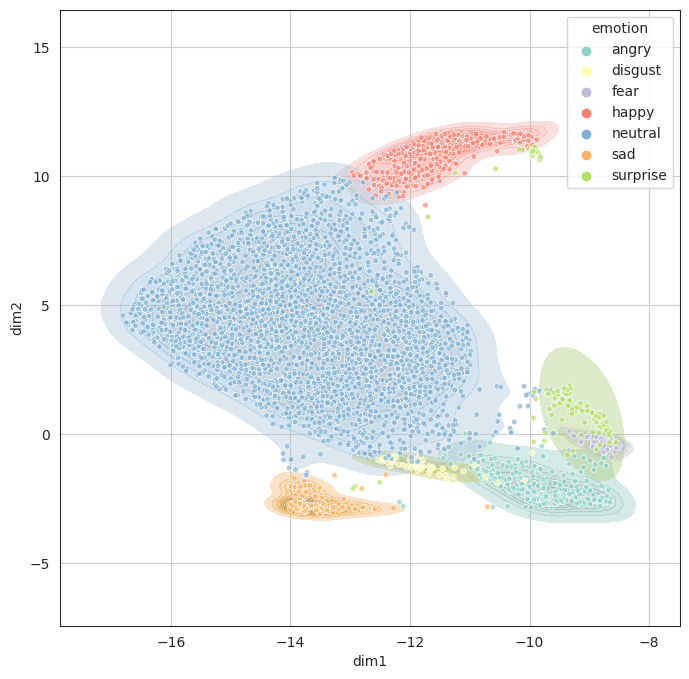

In [64]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        plot_type="kde_scatter",
        n_neighbors=100,
        min_dist=0.3,
        random_state=42)

/tmp/ipykernel_379760/2497574796.py:72: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",
/tmp/ipykernel_379760/2497574796.py:74: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion",


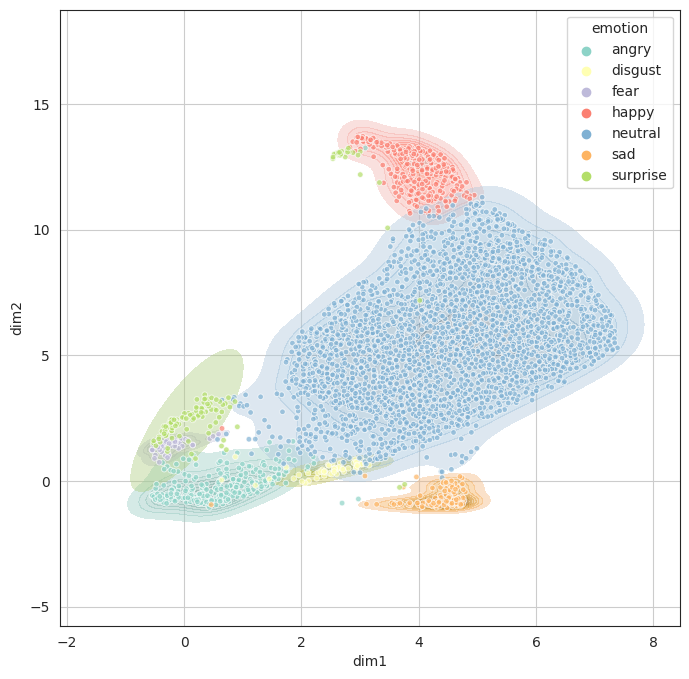

In [66]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        plot_type="kde_scatter",
        n_neighbors=200,
        min_dist=0.3,
        random_state=42)

/tmp/ipykernel_379760/2081477706.py:72: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.kdeplot(data=total_df, x="dim1", y="dim2", hue="emotion",
/tmp/ipykernel_379760/2081477706.py:74: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.scatterplot(data=total_df, x="dim1", y="dim2", hue="emotion",


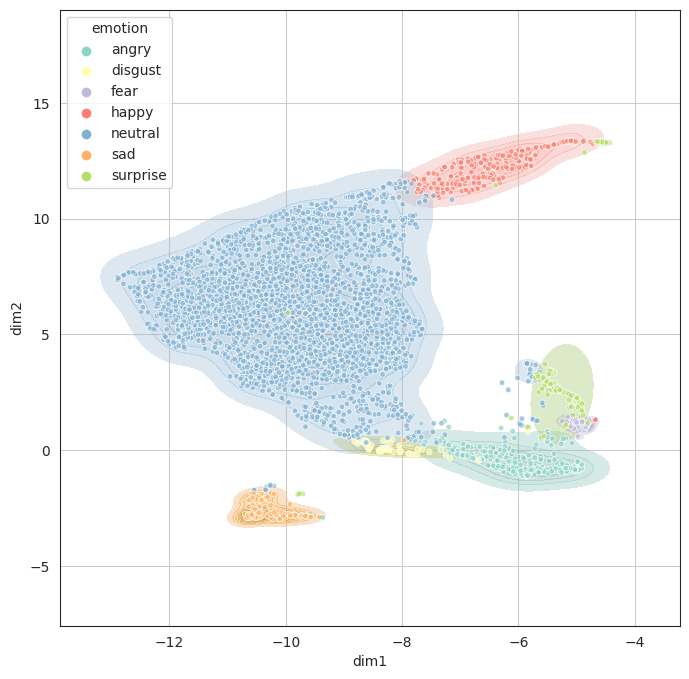

In [ ]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=True,
        incorrect_only=False,
        title="UMAP Linear Pooled | Correct only",
        n_sampling=0,
        plot_type="kde_scatter",
        random_state=42)

In [ ]:
plot_rd(data=total_emb.values,
        total_emotion=total_emotion,
        dim_reduction="umap",
        correct_only=False,
        incorrect_only=True,
        title="UMAP Linear Pooled | Incorrect only",
        n_sampling=0,
        random_state=42)